In [1]:
import os
import numpy as np
import pandas as pd
from lumicks import pylake
from scipy.signal import find_peaks
from matplotlib import pyplot as plt

In [2]:
def find_kymo_ssDNA(kymo_image, max_ss_intensity = 2):
    """
    Find single-stranded DNA (ssDNA) in a kymograph image.

    :param kymo_image: 3D array representing the kymograph image.
    :param max_ss_intensity: Value representing the maximum expected intensity of ssDNA, default = 2
    :return: List of start and end positions of ssDNA regions, or prints 'No ssDNA'/'No dsDNA' if not found.
    """
    # Average the kymograph image along the x-axis to get the DNA signal
    sytox_img_DNA = np.mean(kymo_image[:, :, 1], axis=1)
    
    # Find the brightest pixel value in the second channel of the kymograph image
    brightest_pix = np.max(kymo_image[:, :, 1])

    # Find the signal peaks caused by beads to roughly crop them out
    bead_peaks = find_peaks(sytox_img_DNA, prominence=brightest_pix / 10, width=2.5, height=0, distance=10)
    left_ips = bead_peaks[1]['left_ips']
    right_ips = bead_peaks[1]['right_ips']

    if len(bead_peaks[0]) == 4:
        left_ips = bead_peaks[1]['left_ips']
        right_ips = bead_peaks[1]['right_ips']

    # Crop the DNA region to exclude the beads
    sytox_img_DNA_cropped = sytox_img_DNA[int(right_ips[1]):int(left_ips[2])]
    median1 = np.median(sytox_img_DNA_cropped)
    
    # Determine the median intensities for ssDNA and dsDNA
    if median1 < max_ss_intensity:
        DNA_median = np.median(sytox_img_DNA_cropped[sytox_img_DNA_cropped > median1])
        ssDNA_median = median1
    else:
        ssDNA_median = np.median(sytox_img_DNA_cropped[sytox_img_DNA_cropped < median1])
        DNA_median = median1

    iterations = 0
    while ssDNA_median > max_ss_intensity and iterations < 4:
        ssDNA_median = np.median(sytox_img_DNA_cropped[sytox_img_DNA_cropped < ssDNA_median])
        iterations += 1
    if ssDNA_median > max_ss_intensity:
        print('No ssDNA')
    # Check if the dsDNA median is significantly above the background
    if DNA_median < max_ss_intensity + 2:
        print("No dsDNA?")

    # Threshold the DNA region to the dsDNA median
    median_threshold_indices = sytox_img_DNA_cropped > DNA_median
    sytox_img_DNA_cropped[median_threshold_indices] = DNA_median
    
    # Flip the image upside down and find peaks near the ssDNA median
    sytox_img_DNA_cropped = sytox_img_DNA_cropped * -1

    # Find peaks near the ssDNA median
    ssDNA_peak = find_peaks(sytox_img_DNA_cropped, height=(-ssDNA_median), prominence=(DNA_median - ssDNA_median) * 0.9, width=2, distance=15)

    # Extract the start and end positions of the ssDNA regions
    ssDNA_start = []
    ssDNA_end = []
    for i in range(len(ssDNA_peak[0])):
        ssDNA_start.append(ssDNA_peak[1]['left_ips'][i] + int(right_ips[1]) + 1)
        ssDNA_end.append(ssDNA_peak[1]['right_ips'][i] + int(right_ips[1]) - 1)

    return [ssDNA_start, ssDNA_end]

20241219-125005 Marker 1.h5


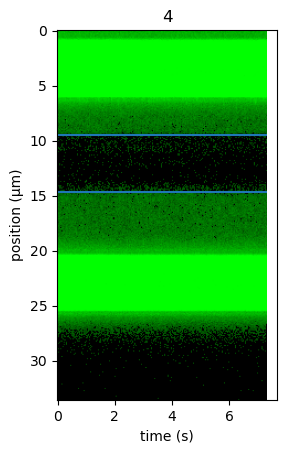

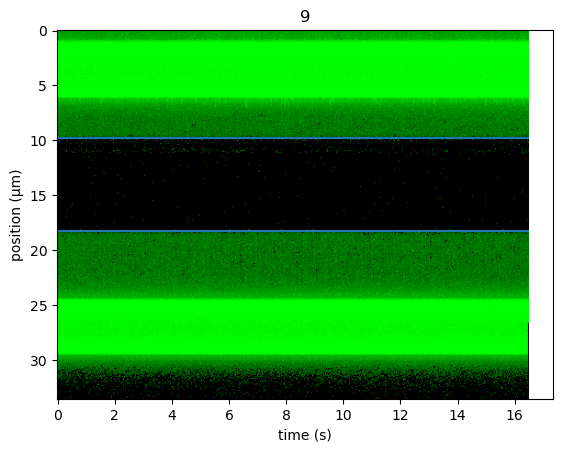

In [3]:
def create_output_folder(data_folder, output_folder_name='sytox_ssDNA_classification/'):
    """
    Create an output folder if it doesn't exist.

    :param data_folder: Path to the data folder.
    :param output_folder_name: Name of the output folder.
    :return: Path to the output folder.
    """
    output_folder = os.path.join(data_folder, output_folder_name)
    if not os.path.exists(output_folder):
        os.mkdir(output_folder)
    return output_folder

def process_kymo(kymo, marker_time_ns, marker_distance, output_folder, file, kymo_id,max_ss_intensity=2):
    """
    Process a kymograph image to find ssDNA and save the results.

    :param kymo: Kymograph object.
    :param marker_time_ns: Timestamps of the marker.
    :param marker_distance: Distance data of the marker.
    :param output_folder: Path to the output folder.
    :param file: File name.
    :param kymo_id: Kymograph ID.
    """
    kymo_img = kymo.get_image()
    
    # Skip kymographs with low mean intensity or long duration
    if np.mean(kymo_img[:, :, 1]) < 8 or kymo.duration > 30:
        return

    try:
        # Plot the kymograph image with color adjustment
        adjustment = pylake.ColorAdjustment([1], [150], mode="absolute", gamma=0.25)
        kymo.plot(channel='green', adjustment=adjustment)
        
        # Find ssDNA start and end positions
        ssDNA_start, ssDNA_end = find_kymo_ssDNA(kymo_img, max_ss_intensity)

        # Plot ssDNA start and end positions on the kymograph
        plt.hlines(ssDNA_start[0] / 10, 0, kymo.duration)
        plt.hlines(ssDNA_end[0] / 10, 0, kymo.duration)
        plt.show()
    except Exception as e:
        print(e)
        return

    # Calculate average distance during the kymograph time period
    kymo_start_time = min(kymo.timestamps[:][0])
    kymo_end_time = max(kymo.timestamps[:][0])
    kymo_time_ns = (marker_time_ns >= kymo_start_time) & (marker_time_ns <= kymo_end_time)
    avg_dist = np.mean(marker_distance[kymo_time_ns])

    # Save the results to a CSV file
    gap_location_dict = {'Distance': avg_dist, 'ssDNA start': ssDNA_start[0], 'ssDNA end': ssDNA_end[0]}
    gap_location_df = pd.DataFrame(gap_location_dict, index=[0])
    gap_location_df.to_csv(f'{output_folder}{file}_kymo{kymo_id}.csv', index=False)

def process_file(data_folder,marker_name, max_ss_intensity = 2):
    """
    Process specified marker.h5 file in the data folder to find and classify ssDNA.

    :param data_folder: Path to the data folder.
    """
    output_folder = create_output_folder(data_folder)
    print(marker_name)
    marker = pylake.File(os.path.join(data_folder, marker_name))
    marker_time_ns = marker['Force LF']['Trap 1'].timestamps
    marker_distance = marker['Distance']['Distance 1'].data
    kymos = marker.kymos
    
    for kymo_id in kymos:
        process_kymo(kymos.get(kymo_id), marker_time_ns, marker_distance, output_folder, marker_name, kymo_id, max_ss_intensity)

# Define the data folder path
data_folder = './test_folder/'
marker_name = '20241219-125005 Marker 1.h5'

# Process all files in the data folder
process_file(data_folder,marker_name, max_ss_intensity=1)
